# Constructing a WCS for Overlappogram Data

In [1]:
import numpy as np
import astropy.units as u
from scipy.io import readsav
import sys
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize,LogStretch
import sunpy.map
import ndcube
from sunpy.coordinates import get_earth
sys.path.append('../scripts')
from util import (make_moxsi_ndcube, 
                  construct_overlappogram,
                  construct_dispersion_matrix,
                  construct_rot_matrix, 
                  overlappogram_wcs,
                  color_lat_lon_axes)

In [16]:
norm=ImageNormalize(vmin=0,vmax=10,stretch=LogStretch())
cmap='hinodexrt'
plot_props = {'cmap':cmap, 'norm':norm}

## Some Notes on the Formalism

From the `PCi_j` formalism, the conversion between intermediate world coordinates and pixel coordinates is given by (from Gei

$$
x_i = s_iq_i \\
q_i = m_{ij}(p_j - r_j)
$$

The resulting `PC_ij` matrix for our overlappogram **assuming that the dispersion direction is aligned with the y-like pixel axis**,

$$
M_{\alpha} = \begin{bmatrix}
\cos\alpha & \sin\alpha & -\mu\sin\alpha \\
-\sin\alpha & \cos\alpha & -\mu\cos\alpha \\
0 & 0 & 1
\end{bmatrix}
$$

Additionally, we apply an additional rotation by $\gamma$ first in order to align our pixel axis with the dispersion axis,

$$
M_\gamma = \begin{bmatrix}
\cos\gamma & \sin\gamma & 0 \\
-\sin\gamma & \cos\gamma & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

We then rotate our intermediate world coordinate back by $-\gamma$ as the dispersion should not affect the orientation of our world grid.
Thus, our full `PC` matrix can be written as,

$$
M = M_\gamma^TM_\alpha M_\gamma
$$

As an aside, to align the $p_2$ and $q_3$ axes, we would modify the last row of $M$ as, 

$$
\begin{bmatrix}
0 & 0 & 1
\end{bmatrix}
\to
\begin{bmatrix}
-\sin\gamma & \cos\gamma & 0
\end{bmatrix}
$$

This has the effect of decoupling $p_3$ from $q_3$.
This is not strictly correct as a given HPC grid mapped to our 2D pixel axis is only valid at a single wavelength, not all wavelengths.
Aligning $p_2$ and $q_3$ breaks that assumption.


## Loading Data

First, load the data into a spectral cube, where each slice represents a different wavelength.

In [47]:
savdata = readsav('../data/forDan_MOXSI_DATA_09112020_0440_feldman.sav')

In [62]:
_moxsi_cube = make_moxsi_ndcube(savdata['moxsi1_img'],savdata['cubixss_wave']*u.angstrom)

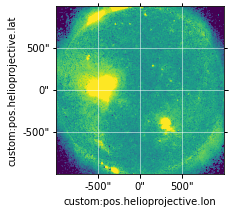

In [63]:
plt.figure(figsize=(3,8))
ax = _moxsi_cube[327].plot(norm=ImageNormalize(vmin=0,vmax=1,stretch=LogStretch()))
lon,lat = ax.coords
lon.grid(color='white', alpha=1, linestyle='solid', lw=.5,)
lat.grid(color='white', alpha=1, linestyle='solid', lw=.5,)

Make the cube sparse here by only including a few wavelengths and filling everything else with 0.
This reduces our need to rotate/shift a bunch of arrays

In [68]:
iw_rank = _moxsi_cube.data.mean(axis=(1,2)).argsort()[::-1]
new_data = np.zeros(_moxsi_cube.data.shape)
for i in iw_rank[:20]:
    new_data[i,:,:] = _moxsi_cube.data[i,:,:]
moxsi_cube = make_moxsi_ndcube(new_data, savdata['cubixss_wave']*u.angstrom)

## Creating the Overlappogram

We can then flatten this to an overlappogram, specifying the roll angle (angle between the pixel and world axes, where 0 corresponds to the y-like pixel axis aligned with latitude) and spectral order.

In [69]:
observer = get_earth()

In [70]:
moxsi_overlap = construct_overlappogram(
    moxsi_cube, 
    roll_angle=0*u.deg,
    dispersion_angle=0*u.deg, 
    observer=observer, 
    order=1,
    correlate_p12_with_wave=False
)

We can then plot the overlappogram at a few different "wavelength slices." Note as we move in wavelength space, our latitude grid shifts along the dispersion axis.

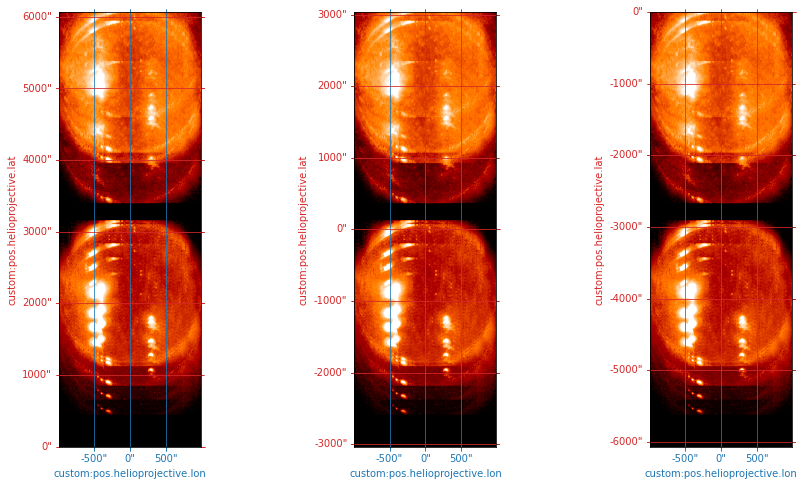

In [71]:
fig = plt.figure(figsize=(15,8))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(1,len(wvl_indices),i+1, projection=moxsi_overlap[iw].wcs)
    moxsi_overlap[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})
    #ax.coords[2].set_format_unit(u.angstrom)
    #ax.coords[2].set_major_formatter('x.x')

### Varying Roll Angle

We can also choose to orient the pixel (and thus the dispersion) axis at some non-zero angle relative to the world axes. This is equivalent to "rolling" our satellite.

In [72]:
moxsi_overlap_r45 = construct_overlappogram(
    moxsi_cube, 
    roll_angle=45*u.deg,
    observer=observer,
    order=1
)

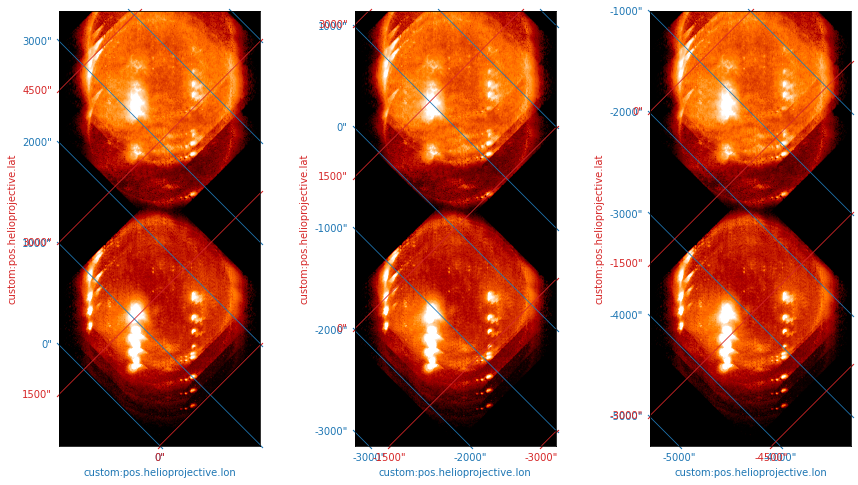

In [73]:
fig = plt.figure(figsize=(15,8))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(1,len(wvl_indices),i+1, projection=moxsi_overlap_r45[iw].wcs)
    moxsi_overlap_r45[iw].plot(axes=ax,**plot_props)
    lon,lat = color_lat_lon_axes(ax,
                                 lon_tick_ops={'spacing':1000*u.arcsec},
                                 lat_tick_ops={'spacing':1500*u.arcsec})
    #ax.coords[2].set_format_unit(u.angstrom)
    #ax.coords[2].set_major_formatter('x.x')

Or completely in the "longitude" direction

In [74]:
moxsi_overlap_r90 = construct_overlappogram(
    moxsi_cube, 
    roll_angle=90*u.deg,
    observer=observer,
    order=1
)

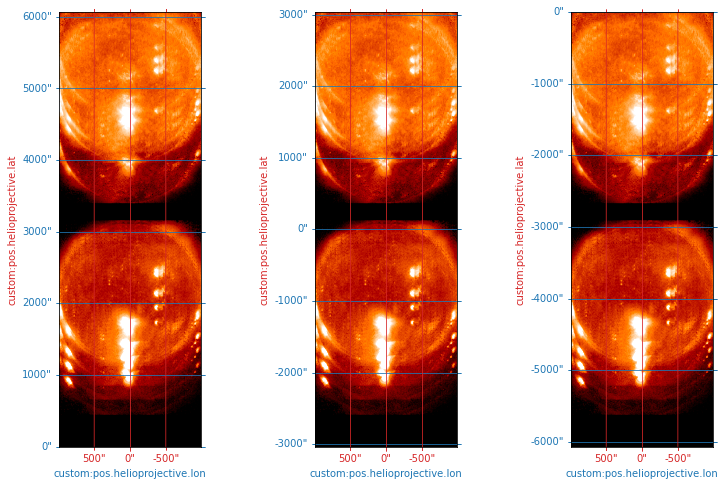

In [75]:
fig = plt.figure(figsize=(13,8))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(1,len(wvl_indices),i+1, projection=moxsi_overlap_r90[iw].wcs)
    moxsi_overlap_r90[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lon_tick_ops={'spacing':1000*u.arcsec})

### Varying Dispersion Angle

We now want to investigate cases where our dispersion angle, the angle between the dispersion axis and the "long" pixel axis, is non-zero.

In [95]:
moxsi_overlap_a0_d5 = construct_overlappogram(
    moxsi_cube, 
    roll_angle=60*u.deg,
    dispersion_angle=10*u.deg,
    observer=observer, 
    order=1,
    correlate_p12_with_wave=True,
)

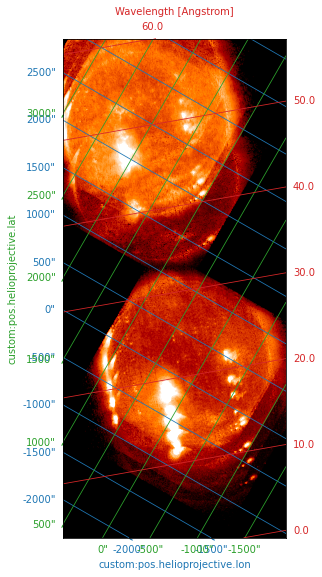

In [101]:
i_w = iw_rank[0]
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(111, projection=moxsi_overlap_a0_d5[i_w].wcs)
moxsi_overlap_a0_d5[i_w].plot(axes=ax,**plot_props)
lon,lat = color_lat_lon_axes(ax,
                             lat_color='C2',
                             lon_tick_ops={'spacing':500*u.arcsec},
                             lat_tick_ops={'spacing':500*u.arcsec})
if len(ax.coords.get_coord_range()) > 2:
    ax.coords[2].set_ticklabel_position('rt')
    ax.coords[2].set_format_unit(u.angstrom)
    ax.coords[2].set_major_formatter('x.x')
    ax.coords[2].set_ticklabel(color='C3')
    ax.coords[2].set_ticks(color='C3')
    ax.coords[2].set_axislabel('Wavelength [Angstrom]',color='C3')
    ax.coords[2].grid(color='C3',grid_type='contours')

Some testing with the WCS

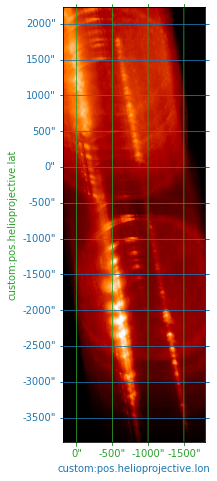

In [33]:
disp = 45*u.deg
roll = 0*u.deg
foo_wcs = overlappogram_wcs(
    moxsi_overlap_a0_d5.data.shape,
    moxsi_cube.axis_world_coords(0)[0].to('angstrom'),
    moxsi_overlap_a0_d5.wcs.wcs.cdelt,
    moxsi_overlap_a0_d5.wcs.wcs.cunit,
    construct_dispersion_matrix(disp) @ construct_rot_matrix(roll, 1) @ construct_dispersion_matrix(disp),
    observer,
)
foo_overlap = ndcube.NDCube(moxsi_overlap_a0_d5.data, wcs=foo_wcs)
i_w = 1072//2 + 200
fig = plt.figure(figsize=(3,8))
ax = fig.add_subplot(111, projection=foo_overlap[i_w].wcs)
foo_overlap[i_w].plot(axes=ax,**plot_props)
lon,lat = color_lat_lon_axes(ax,
                             lat_color='C2',
                             lon_tick_ops={'spacing':500*u.arcsec},
                             lat_tick_ops={'spacing':500*u.arcsec})

In [34]:
moxsi_overlap_a25_d5 = construct_overlappogram(
    moxsi_cube, 
    roll_angle=25*u.deg,
    dispersion_angle=10*u.deg,
    observer=observer, 
    order=1,
    correlate_p12_with_wave=False,
)

In [36]:
moxsi_overlap_a25_d0 = construct_overlappogram(
    moxsi_cube, 
    roll_angle=25*u.deg,
    dispersion_angle=0*u.deg,
    observer=observer, 
    order=1,
    correlate_p12_with_wave=False,
)

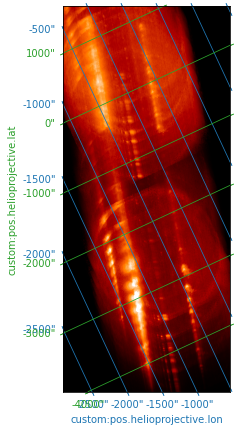

In [42]:
i_w = 1072//2 + 300
fig = plt.figure(figsize=(3,8))
ax = fig.add_subplot(111, projection=moxsi_overlap_a25_d5[i_w].wcs)
moxsi_overlap_a25_d5[i_w].plot(axes=ax,**plot_props)
lon,lat = color_lat_lon_axes(ax,
                             lat_color='C2',
                             lon_tick_ops={'spacing':500*u.arcsec},
                             lat_tick_ops={'spacing':1000*u.arcsec})
#ax.coords[2].set_ticklabel_position('rt')
#ax.coords[2].set_format_unit(u.angstrom)
#ax.coords[2].set_major_formatter('x.x')
#ax.coords[2].set_ticklabel(color='C3')
#ax.coords[2].set_ticks(color='C3')
#ax.coords[2].set_axislabel('Wavelength [Angstrom]',color='C3')
#ax.coords[2].grid(color='C3',grid_type='contours')

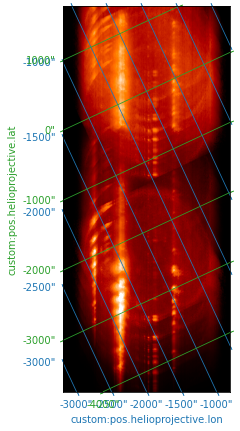

In [41]:
i_w = 1072//2 + 300
fig = plt.figure(figsize=(3,8))
ax = fig.add_subplot(111, projection=moxsi_overlap_a25_d0[i_w].wcs)
moxsi_overlap_a25_d0[i_w].plot(axes=ax,**plot_props)
lon,lat = color_lat_lon_axes(ax,
                             lat_color='C2',
                             lon_tick_ops={'spacing':500*u.arcsec},
                             lat_tick_ops={'spacing':1000*u.arcsec})
#ax.coords[2].set_ticklabel_position('rt')
#ax.coords[2].set_format_unit(u.angstrom)
#ax.coords[2].set_major_formatter('x.x')
#ax.coords[2].set_ticklabel(color='C3')
#ax.coords[2].set_ticks(color='C3')
#ax.coords[2].set_axislabel('Wavelength [Angstrom]',color='C3')
#ax.coords[2].grid(color='C3',grid_type='contours')

### Varying Spectral Order

In [ ]:
m1 = construct_overlappogram(moxsi_cube,roll_angle=0*u.deg,order=1,observer=observer)
m3 = construct_overlappogram(moxsi_cube,roll_angle=0*u.deg,order=3,observer=observer)

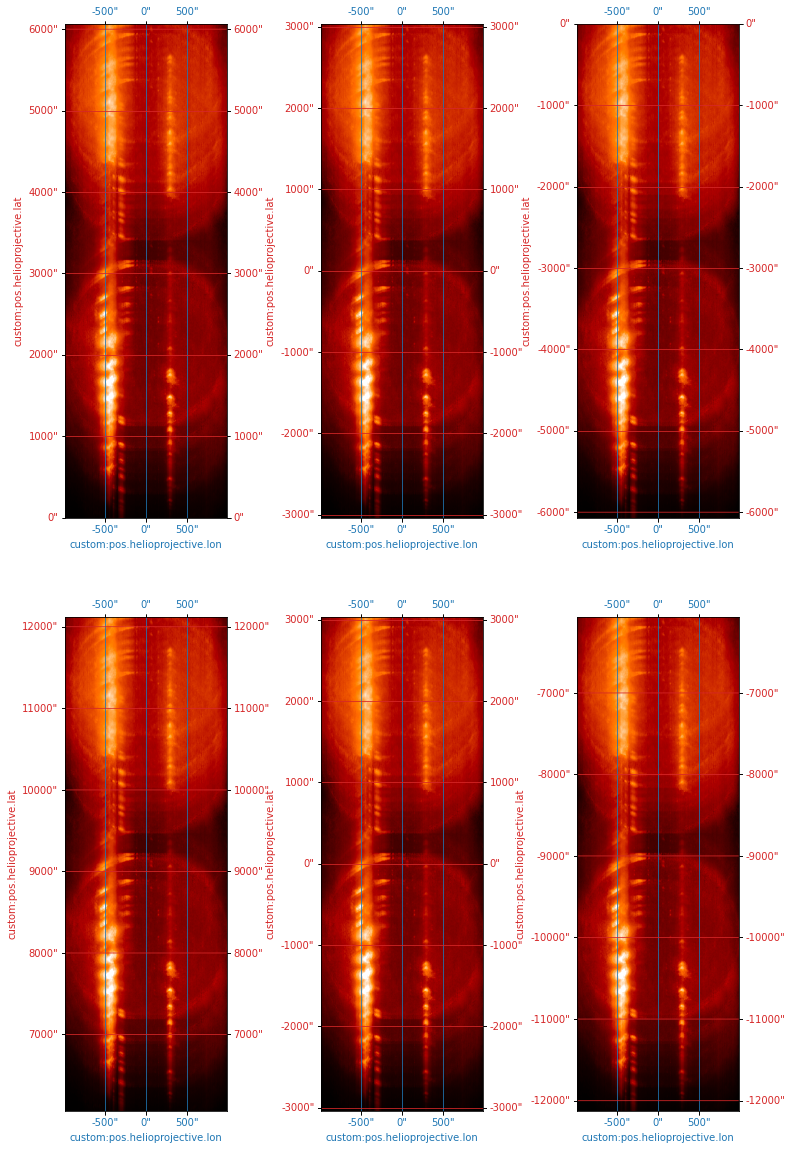

In [ ]:
fig = plt.figure(figsize=(13,20))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(2,len(wvl_indices),i+1, projection=m1[iw].wcs)
    m1[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(2,len(wvl_indices),len(wvl_indices)+i+1, projection=m3[iw].wcs)
    m3[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})